In [ ]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 7.2 MB/s 
     |████████████████████████████████| 3.3 MB 85.7 MB/s 
     |████████████████████████████████| 59 kB 8.1 MB/s 
     |████████████████████████████████| 895 kB 74.9 MB/s 
     |████████████████████████████████| 596 kB 68.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from dataclasses import dataclass
import pandas as pd
import numpy as np
import glob
import re
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
path = '/Bert_Base_Cased'

## Set-up Configuration

## Load the data

We will first download the IMDB data and load into a Pandas dataframe.

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,   as_supervised=True)

train_dataset, test_dataset = dataset['train'], dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteX6MZ25/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteX6MZ25/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteX6MZ25/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
dataset = test_dataset.concatenate(train_dataset)

In [ ]:
max_length_word = 128
min_length_word = 64

In [ ]:
def dataset_fn(ds):
  return ds.filter(lambda x, y: len(tf.strings.split(x)) < max_length_word and len(tf.strings.split(x)) > min_length_word)

In [ ]:
dataset = dataset.apply(dataset_fn)

In [ ]:
for x,y in dataset:
  print(x.numpy(),y)
  break

b'As a former Erasmus student I enjoyed this film very much. It was so realistic and funny. It really picked up the spirit that exists among Erasmus students. I hope, many other students will follow this experience, too. However, I wonder if this movie is all that interesting to watch for people with no international experience. But at least one of my friends who has never gone on Erasmus also enjoyed it very much. I give it 9 out of 10.' tf.Tensor(1, shape=(), dtype=int64)


In [ ]:
j=0
for _,_ in enumerate(dataset):
    j=j+1
total_num = j
print(j)

10265


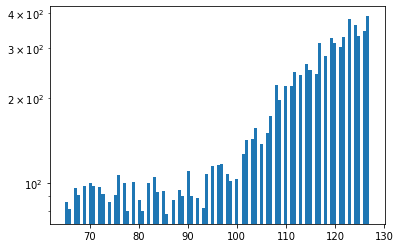

In [ ]:
plt.hist([len(s.numpy().split()) for s,y in dataset],log=True, bins=100)
plt.show()

In [ ]:
asd = []
for sent,y in dataset:
    asd.extend(sent.numpy().split())

In [ ]:
len(set(asd))

93745

In [ ]:
seq_len = 128

In [ ]:
from transformers import BertTokenizer

# initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', cache_dir=path)
vocab =len(tokenizer)
vocab

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

28996

In [ ]:
def tokenize_sentence(x):
    token = tokenizer(x.numpy().decode(), max_length=seq_len, truncation=True,
                   padding='max_length', add_special_tokens=True, return_token_type_ids=False,
                   return_tensors='tf')
    return token

In [ ]:
input_ids = []
attention_mask = []
for x,y in dataset:
    inp = tokenize_sentence(x)
    input_ids.append(inp['input_ids'].numpy()[0])
    attention_mask.append(inp['attention_mask'].numpy()[0])

In [ ]:
input_ids = np.array(input_ids)
attention_mask = np.array(attention_mask)

In [ ]:
input_ids.shape, attention_mask.shape

((10265, 128), (10265, 128))

In [ ]:
data = tf.data.Dataset.from_tensor_slices((input_ids,  attention_mask))

In [ ]:
for x, y in data:
    print(x)
    break

tf.Tensor(
[  101  1249   170  1393 14903 23283  2377   146  4927  1142  1273  1304
  1277   119  1135  1108  1177 13142  1105  6276   119  1135  1541  3015
  1146  1103  4840  1115  5903  1621 14903 23283  1651   119   146  2810
   117  1242  1168  1651  1209  2812  1142  2541   117  1315   119  1438
   117   146  4608  1191  1142  2523  1110  1155  1115  5426  1106  2824
  1111  1234  1114  1185  1835  2541   119  1252  1120  1655  1141  1104
  1139  2053  1150  1144  1309  2065  1113 14903 23283  1145  4927  1122
  1304  1277   119   146  1660  1122   130  1149  1104  1275   119   102
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0], shape=(128,), dtype=int32)


In [ ]:
tokenizer.decode(x)

'[CLS] As a former Erasmus student I enjoyed this film very much. It was so realistic and funny. It really picked up the spirit that exists among Erasmus students. I hope, many other students will follow this experience, too. However, I wonder if this movie is all that interesting to watch for people with no international experience. But at least one of my friends who has never gone on Erasmus also enjoyed it very much. I give it 9 out of 10. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
mask_index = 103

# Mask Word Setup

In [ ]:
# Mask some words to learn 
def masking_word(train_padded, train_mask):
    mask1 = (tf.random.uniform([seq_len],  minval=0., maxval=1.) < 0.15)
    mask2 = (train_padded != 101)
    mask3 = (train_padded != 102)
    mask4 = (train_padded != 0)
    mask = tf.cast(mask1, tf.int32)*tf.cast(mask2, tf.int32)*tf.cast(mask3, tf.int32)*tf.cast(mask4, tf.int32)
    y_l = tf.where(train_padded > 1,mask, train_padded)
    train_masked = train_padded-y_l*train_padded+y_l*mask_index
    train_masked = train_masked
    train_label = train_padded
    return train_masked,train_mask, train_label

In [ ]:
dataset = data.map(lambda x, y: (masking_word(x, y)))

In [ ]:
for masked in dataset:
    print(masked)
    break

(<tf.Tensor: shape=(128,), dtype=int32, numpy=
array([  101,  1249,   103,  1393, 14903, 23283,  2377,   146,  4927,
        1142,  1273,   103,  1277,   119,  1135,   103,  1177, 13142,
        1105,  6276,   119,  1135,  1541,  3015,   103,   103,  4840,
        1115,  5903,  1621, 14903, 23283,  1651,   119,   146,  2810,
         117,  1242,  1168,  1651,  1209,  2812,  1142,  2541,   117,
        1315,   119,  1438,   117,   146,  4608,  1191,  1142,  2523,
         103,  1155,  1115,  5426,  1106,   103,  1111,  1234,  1114,
        1185,  1835,  2541,   119,  1252,  1120,  1655,  1141,  1104,
        1139,  2053,  1150,   103,  1309,   103,  1113, 14903, 23283,
        1145,  4927,  1122,  1304,  1277,   119,   146,  1660,  1122,
         130,  1149,  1104,  1275,   119,   102,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,  

In [ ]:
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

In [ ]:
dataset = dataset.map(map_func)

In [ ]:
BATCH_SIZE = 64
ds = dataset.shuffle(total_num)
ds = ds.batch(BATCH_SIZE, drop_remainder=False)

In [ ]:
train_split = 0.9
val_split = 0.1
train_size = int(train_split * total_num/BATCH_SIZE)
    
train_ds = ds.take(train_size)    
val_ds = ds.skip(train_size)

# Model Setup

In [ ]:
from transformers import TFAutoModel, TFBertForTokenClassification

In [ ]:
bert = TFAutoModel.from_pretrained('bert-base-cased', cache_dir=path)  #, output_hidden_states=False

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
model = TFBertForTokenClassification.from_pretrained(
"bert-base-cased",
num_labels=vocab,
output_attentions = False,
output_hidden_states = False
)

All model checkpoint layers were used when initializing TFBertForTokenClassification.

Some layers of TFBertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

In [ ]:
@tf.function
def train_step(inp, tar):
  with tf.GradientTape() as tape:
    logits = model(inp['input_ids'], token_type_ids=None, attention_mask=inp['attention_mask']).logits
    loss = loss_object(tar, logits)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  train_accuracy.update_state(tar, logits)
  return loss
def val_step(inp, tar):
    logits = model(inp['input_ids'], token_type_ids=None, attention_mask=inp['attention_mask']).logits
    loss = loss_object(tar, logits)
    val_accuracy.update_state(tar, logits)
    return loss

In [ ]:
EPOCHS =10

history = {
  "epoch": [],
  "loss": [],
  "Accuracy" :[],
  "Val_loss": [],
  "Val_Accuracy":[]  
}
for epoch in range(EPOCHS):
  start = time.time()
  total_loss = 0
  val_loss = 0
#  train_loss.reset_states()
  for (batchx, (inp, tar)) in enumerate(train_ds):
    batch_loss = train_step(inp, tar)
    total_loss = total_loss+batch_loss
  history['epoch'].append(epoch)
  history['loss'].append(total_loss/(batchx+1))
  history['Accuracy'].append(train_accuracy.result())
  # TEST LOOP
  for (batch, (inp, tar)) in enumerate(val_ds):
    batch_loss = val_step(inp, tar)
    val_loss = val_loss+batch_loss
  history['Val_loss'].append(val_loss/(batch+1))
  history['Val_Accuracy'].append(val_accuracy.result())
  print(f'Epoch {epoch+1}, Loss: {total_loss/(batchx+1):.4f}, Accuracy: {train_accuracy.result():.4f}, Validation Loss: {val_loss/(batch+1):.4f} Validation Accuracy: {val_accuracy.result():.4f}') 
  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
  train_accuracy.reset_states()

  val_accuracy.reset_states()

Epoch 1, Loss: 3.9500, Accuracy: 0.6449, Validation Loss: 1.8921 Validation Accuracy: 0.8434
Time taken for 1 epoch: 168.40 secs

Epoch 2, Loss: 1.4676, Accuracy: 0.8728, Validation Loss: 1.1408 Validation Accuracy: 0.8948
Time taken for 1 epoch: 157.59 secs

Epoch 3, Loss: 0.9986, Accuracy: 0.9000, Validation Loss: 0.8484 Validation Accuracy: 0.9090
Time taken for 1 epoch: 157.47 secs

Epoch 4, Loss: 0.8001, Accuracy: 0.9089, Validation Loss: 0.7251 Validation Accuracy: 0.9134
Time taken for 1 epoch: 157.94 secs

Epoch 5, Loss: 0.6909, Accuracy: 0.9139, Validation Loss: 0.6468 Validation Accuracy: 0.9165
Time taken for 1 epoch: 157.58 secs

Epoch 6, Loss: 0.6215, Accuracy: 0.9173, Validation Loss: 0.5967 Validation Accuracy: 0.9189
Time taken for 1 epoch: 157.65 secs

Epoch 7, Loss: 0.5705, Accuracy: 0.9203, Validation Loss: 0.5435 Validation Accuracy: 0.9217
Time taken for 1 epoch: 157.63 secs

Epoch 8, Loss: 0.5368, Accuracy: 0.9223, Validation Loss: 0.5221 Validation Accuracy: 0.92

# Evaluate


In [ ]:
def masked_sentence(sentenceX):
    sentence = tokenizer(tf.compat.as_str_any(sentenceX), max_length=seq_len, truncation=True,
                   padding='max_length', add_special_tokens=True, return_token_type_ids=False,
                   return_tensors='tf')
    input = {'input_ids': sentence.input_ids, 'attention_mask': sentence.attention_mask}
    logits = model(input).logits
    prob = tf.argmax(logits, axis=-1)
    print(tokenizer.decode(prob[0].numpy()))

In [ ]:
masked_sentence(u'I have [MASK] this movie and it was terible')

[CLS] I have seen this movie and it was terible [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [ ]:
masked_sentence(u'this was an [MASK] movie dont be fooled in by thomas')

[CLS] this was an excellent movie dont be fooled in by thomas [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [ ]:
masked_sentence(u'this was an [MASK] movie dont be [MASK] by presence of thomas')

[CLS] this was an excellent movie dont be disappointed by presence of thomas [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
